In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from google.colab import drive
from transformers import BertForSequenceClassification
from peft import LoraConfig, TaskType
from peft import get_peft_model
from tqdm import tqdm
import pandas as pd

In [2]:
NAICS_2022 = pd.read_csv('NAICS_2022.csv')

NAICS_2022['INDUSTRY_GROUP'] = NAICS_2022['Code']//100

NAICS_2022 = NAICS_2022.dropna(subset=['EXAMPLE']).reset_index(drop=True)

# We define a function called extract_examples whose input is a text and output is a list of words
# which are extracted from that text. After doing some preprocess on the text, we split the text by semi-colon.

def extract_examples(text):
    # Lowercase the text
    text = text.lower()
    text = text.replace('for example, ','')
    
    # Remove punctuation marks
    #text = ''.join(char for char in text if char not in punctuation_without_semicolon)
    
    # Remove stopwords
    words = text.split()
    #words = [word for word in words if word not in stopwords]
    
    for i in range(len(words)):
        if ";" in words[i]:
            word = words[i].replace(";", "")
            stemmed_word = word + ";"
            words[i] = stemmed_word        
        #else:
         #   words[i] = stemmer.stem(words[i])
    
    
    
    # Stem the words
    #words = [stemmer.stem(word) for word in words]
    
    # Join the words back into a string
    text = ' '.join(words)
    
    list_words = text.rstrip('; ').split(';')
    # Use Yake to extract keywords from the preprocessed text
    #keywords = custom_kw_extractor.extract_keywords(text)
    #keywords = [t[0] for t in keywords]
    #if len(keywords) != 1:
       # keywords = [t for t in keywords if len(t.split()) > 1]
        
    #keywords = [t[0] for t in keywords if len(t[0].split()) > 1]
    
    return list_words


# Here we apply the extract_examples function on the EXAMPLE column of the dataset. 
# EXAMPLE column comprises of many examples which are separated by semi-colon.

NAICS_2022['EXAMPLE_SPLIT'] = NAICS_2022['EXAMPLE'].apply(lambda x: extract_examples(x))


# Labeling the INDUSTRY_GROUP column: we have 312 classes in the industry group level (first 4 digits of NAICS code)
# and we label them from 0 to 311.

INPUT_DF = NAICS_2022.copy()


INPUT_DF_EXPLODE = INPUT_DF.explode('EXAMPLE_SPLIT').reset_index(drop = True)

value_counts = INPUT_DF_EXPLODE['Code'].value_counts()
# Get the values that occur more than once
values_to_keep = value_counts[value_counts > 1].index

# Filter the DataFrame to keep only rows where the value in 'a' occurs more than once
INPUT_DF_EXPLODE = INPUT_DF_EXPLODE[INPUT_DF_EXPLODE['Code'].isin(values_to_keep)].reset_index(drop = True)

mapping_IG = {sec:idx for idx, sec in enumerate(list(INPUT_DF_EXPLODE.INDUSTRY_GROUP.unique()))}
INPUT_DF_EXPLODE['industry_group_label'] = INPUT_DF_EXPLODE['INDUSTRY_GROUP'].map(mapping_IG)

mapping_NAICS = {sec:idx for idx, sec in enumerate(list(INPUT_DF_EXPLODE.Code.unique()))}
INPUT_DF_EXPLODE['naics_label'] = INPUT_DF_EXPLODE['Code'].map(mapping_NAICS)

mapping_IG_reverse = {v:k for k, v in mapping_IG.items()}
mapping_NAICS_reverse = {v:k for k, v in mapping_NAICS.items()}

INPUT_DF_EXPLODE_SELECT = INPUT_DF_EXPLODE[['Class definition','EXAMPLE_SPLIT','industry_group_label','naics_label']]



In [3]:
NAICS_2022

,Level,Hierarchical structure,Code,Parent,Class title,Superscript,Class definition,EXAMPLE,INDUSTRY_GROUP,EXAMPLE_SPLIT
0,5,Canadian industry,111110,11111,Soybean farming,NaN,This Canadian industry comprises establishment...,"soybean farming, field and seed production; s...",1111,"[soybean farming, field and seed production, ..."
1,5,Canadian industry,111120,11112,Oilseed (except soybean) farming,US,This Canadian industry comprises establishment...,canola (rapeseed) farming; linseed (flaxseed)...,1111,"[canola (rapeseed) farming, linseed (flaxseed..."
2,5,Canadian industry,111130,11113,Dry pea and bean farming,US,This Canadian industry comprises establishment...,bean or pea farming (field crop); dry bean fa...,1111,"[bean or pea farming (field crop), dry bean f..."
3,5,Canadian industry,111140,11114,Wheat farming,NaN,This Canadian industry comprises establishment...,"wheat (i.e., spring, winter and durum) growin...",1111,"[wheat (i.e., spring, winter and durum) growin..."
4,5,Canadian industry,111150,11115,Corn farming,US,This Canadian industry comprises establishment...,"corn (except sweet corn) farming, field and s...",1111,"[corn (except sweet corn) farming, field and s..."
...,...,...,...,...,...,...,...,...,...,...
918,5,Canadian industry,913910,91391,"Other local, municipal and regional public adm...",CAN,This Canadian industry comprises establishment...,"adult education program, local; amusement tax...",9139,"[adult education program, local, amusement ta..."
919,5,Canadian industry,914111,91411,First Nations public administration,CAN,This Canadian industry comprises establishment...,First Nations Band Council; First Nations Sel...,9141,"[first nations band council, first nations se..."
920,5,Canadian industry,914112,91411,MÃ©tis public administration,CAN,This Canadian industry comprises establishment...,Métis Self-Government;,9141,[métis self-government]
921,5,Canadian industry,914113,91411,Inuit public administration,CAN,This Canadian industry comprises establishment...,Inuit Self-Government;,9141,[inuit self-government]


In [4]:
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available. Using CPU.")

GPU is available!


In [5]:
len(INPUT_DF_EXPLODE_SELECT)

19138

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    INPUT_DF_EXPLODE_SELECT['EXAMPLE_SPLIT'],
    INPUT_DF_EXPLODE_SELECT['naics_label'],
    test_size=0.1,
    random_state=42,
    stratify=INPUT_DF_EXPLODE_SELECT['naics_label']
)

In [7]:
roberta_checkpoint = "roberta-large"
roberta_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(roberta_checkpoint, add_prefix_space=True)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True, return_tensors='pt')

In [8]:
# Convert labels to tensors
train_labels = torch.tensor(list(y_train))
valid_labels = torch.tensor(list(y_valid))


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_encodings = {key: val.to(device) for key, val in train_encodings.items()}
valid_encodings = {key: val.to(device) for key, val in valid_encodings.items()}
train_labels = train_labels.to(device)
valid_labels = valid_labels.to(device)

In [10]:
train_encodings

{'input_ids': tensor([[    0,  5671, 10867,  ...,     1,     1,     1],
         [    0,   786,    12,  ...,     1,     1,     1],
         [    0,  4049,   785,  ...,     1,     1,     1],
         ...,
         [    0, 27402, 12868,  ...,     1,     1,     1],
         [    0,  1123,   516,  ...,     1,     1,     1],
         [    0,  6185,  8671,  ...,     1,     1,     1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming train_encoding and train_labels are your input data
train_dataset = TensorDataset(train_encodings['input_ids'], 
                              #train_encodings['token_type_ids'], 
                              train_encodings['attention_mask'], 
                              train_labels)


In [12]:
# Set batch size according to your preference
batch_size = 16

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [13]:
valid_dataset = TensorDataset(valid_encodings['input_ids'], 
                              #valid_encodings['token_type_ids'], 
                              valid_encodings['attention_mask'], 
                              valid_labels)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [14]:
NUM_CLASS = len(list(set(list(y_train))))

In [15]:
from transformers import AutoModelForSequenceClassification 
model = AutoModelForSequenceClassification.from_pretrained(roberta_checkpoint, num_labels=NUM_CLASS)



lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=1, lora_dropout=0.1
)

model = get_peft_model(model, lora_config)

# Set up training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.to(device)

# Count trainable parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

# Count total parameters (including non-trainable)
num_total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_total_params}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 1553765
Total number of parameters: 126867658


In [16]:
1553765/126867658

0.012247132362134407

In [17]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      

In [17]:
torch.cuda.empty_cache()

In [18]:
import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel


# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = DataParallel(model)

# Move the model to GPU(s)
model = model.cuda()

# Now you can use the model as usual


In [19]:
import torch

# Limit GPU memory growth
#torch.cuda.set_per_process_memory_fraction(0.8)  # Adjust the fraction as needed


In [20]:
#pip install nvidia-ml-py3

In [21]:
from transformers import  AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, balanced_accuracy_score
from tqdm import tqdm
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
# Number of training epochs
NUM_EPOCHS = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()



# Lists to store training losses and F1 scores
train_losses = []
valid_losses = []
f1_scores = []
balanced_accuracies = []
# Training loop with tqdm




for epoch in range(NUM_EPOCHS):
    torch.cuda.empty_cache()
    model.train()
    total_train_loss = 0.0



    # Use tqdm to create a progress bar
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=False)

    for batch in progress_bar:
        input_ids,  attention_mask, labels = batch

        optimizer.zero_grad()
        #print('1')

        outputs = model(input_ids,  attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_train_loss += loss.item()
        #os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to prevent exploding gradients
        #print('2')
        

        optimizer.step()
        scheduler.step()

        #print('3')

        # Update the tqdm progress bar with the current loss
        progress_bar.set_postfix({'Training Loss': loss.item()})

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    total_valid_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids,  attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_valid_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_dataloader)
    valid_losses.append(average_valid_loss)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    f1_scores.append(f1)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    balanced_accuracies.append(balanced_acc)

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}:')
    print(f'Training Loss: {average_train_loss}')
    print(f'Validation Loss: {average_valid_loss}')
    print(f'F1 Score: {f1}')
    print(f'Balanced Accuracy: {balanced_acc}')
    print('-' * 50)


Epoch 1/10:
Training Loss: 4.98940295672793
Validation Loss: 3.6232324957847597
F1 Score: 0.2187164742250241
Balanced Accuracy: 0.1256822272443206
--------------------------------------------------


Epoch 2/10:
Training Loss: 3.159286490721955
Validation Loss: 2.5696364750464755
F1 Score: 0.38660339038530955
Balanced Accuracy: 0.2530179917406671
--------------------------------------------------


Epoch 3/10:
Training Loss: 2.249500429674554
Validation Loss: 1.9641738846898078
F1 Score: 0.5024658128951804
Balanced Accuracy: 0.35973980792783516
--------------------------------------------------


Epoch 4/10:
Training Loss: 1.6444523748193722
Validation Loss: 1.676612880329291
F1 Score: 0.5756450116780782
Balanced Accuracy: 0.457881338678371
--------------------------------------------------


Epoch 5/10:
Training Loss: 1.2325866079596093
Validation Loss: 1.43293275659283
F1 Score: 0.6358896028755044
Balanced Accuracy: 0.5291728054897296
--------------------------------------------------


Epoch 6/10:
Training Loss: 0.935484853696801
Validation Loss: 1.3064019580682118
F1 Score: 0.6637741151204591
Balanced Accuracy: 0.5670471068758427
--------------------------------------------------


C:\Users\User\Desktop\Lora 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 7/10:
Training Loss: 0.7208373339478352
Validation Loss: 1.2304013182719549
F1 Score: 0.6992074355306855
Balanced Accuracy: 0.6234167913980311
--------------------------------------------------


C:\Users\User\Desktop\Lora 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 8/10:
Training Loss: 0.5673930868783148
Validation Loss: 1.1763686694204807
F1 Score: 0.7185716828228113
Balanced Accuracy: 0.6539083103029213
--------------------------------------------------


C:\Users\User\Desktop\Lora 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 9/10:
Training Loss: 0.46182852845462585
Validation Loss: 1.1351742948095003
F1 Score: 0.7262189600054179
Balanced Accuracy: 0.665202478590558
--------------------------------------------------


Epoch 10/10:
Training Loss: 0.4005375057943131
Validation Loss: 1.1207801630099614
F1 Score: 0.7301935677946371
Balanced Accuracy: 0.6682491711791143
--------------------------------------------------


C:\Users\User\Desktop\Lora 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [82]:
with open('train_losses_roberta_naics.txt', 'w') as file:
    for item in train_losses:
        file.write(f"{item}\n")

with open('valid_losses_roberta_naics.txt', 'w') as file:
    for item in valid_losses:
        file.write(f"{item}\n")

with open('f1_scores_roberta_naics.txt', 'w') as file:
    for item in f1_scores:
        file.write(f"{item}\n")

with open('balanced_accuracies_roberta_naics.txt', 'w') as file:
    for item in balanced_accuracies:
        file.write(f"{item}\n")

Loading Roberta results

In [83]:
with open('train_losses_roberta_naics.txt', 'r') as file:
    train_losses_roberta_naics = [float(line.strip()) for line in file]

with open('valid_losses_roberta_naics.txt', 'r') as file:
    valid_losses_roberta_naics = [float(line.strip()) for line in file]

with open('f1_scores_roberta_naics.txt', 'r') as file:
    f1_scores_roberta_naics = [float(line.strip()) for line in file]

with open('balanced_accuracies_roberta_naics.txt', 'r') as file:
    balanced_accuracies_roberta_naics = [float(line.strip()) for line in file]



Loading Bert results


In [84]:
with open('train_losses_bert_naics.txt', 'r') as file:
    train_losses_bert_naics = [float(line.strip()) for line in file]

with open('valid_losses_bert_naics.txt', 'r') as file:
    valid_losses_bert_naics = [float(line.strip()) for line in file]

with open('f1_scores_bert_naics.txt', 'r') as file:
    f1_scores_bert_naics = [float(line.strip()) for line in file]

with open('balanced_accuracies_bert_naics.txt', 'r') as file:
    balanced_accuracies_bert_naics = [float(line.strip()) for line in file]



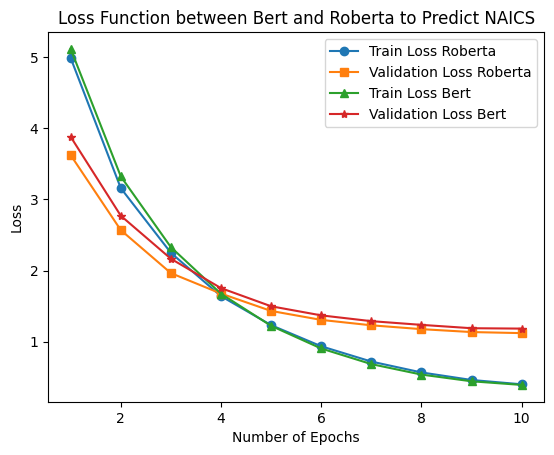

In [94]:
import matplotlib.pyplot as plt


x = [1, 2, 3, 4, 5,6,7,8,9,10]
plt.plot(x, train_losses_roberta_naics, label='Train Loss Roberta', marker='o')
plt.plot(x, valid_losses_roberta_naics, label='Validation Loss Roberta', marker='s')
plt.plot(x, train_losses_bert_naics, label='Train Loss Bert', marker='^')
plt.plot(x, valid_losses_bert_naics, label='Validation Loss Bert', marker='*')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Function between Bert and Roberta to Predict NAICS')
plt.legend()
plt.savefig('loss_naics.jpg', format='jpg', dpi=300)
plt.show()

In [90]:
plt.savefig('loss_naics.jpg', format='jpg', dpi=300)

<Figure size 640x480 with 0 Axes>

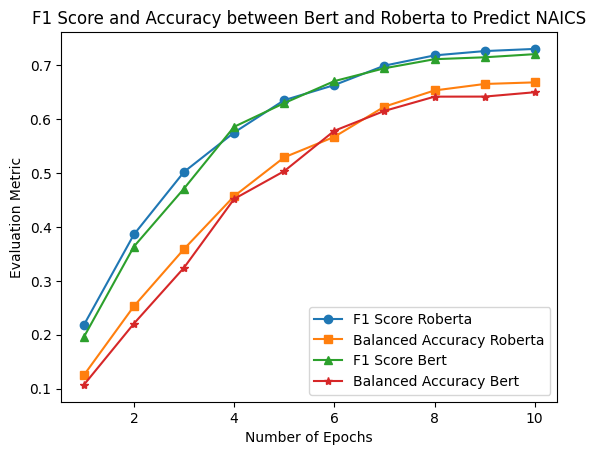

In [96]:
import matplotlib.pyplot as plt


x = [1, 2, 3, 4, 5,6,7,8,9,10]
plt.plot(x, f1_scores_roberta_naics, label='F1 Score Roberta', marker='o')
plt.plot(x, balanced_accuracies_roberta_naics, label='Balanced Accuracy Roberta', marker='s')
plt.plot(x, f1_scores_bert_naics, label='F1 Score Bert', marker='^')
plt.plot(x, balanced_accuracies_bert_naics, label='Balanced Accuracy Bert', marker='*')
plt.xlabel('Number of Epochs')
plt.ylabel('Evaluation Metric')
plt.title('F1 Score and Accuracy between Bert and Roberta to Predict NAICS')
plt.legend()
plt.savefig('evaluation_naics.jpg', format='jpg', dpi=300)
plt.show()

In [22]:
#torch.save(model.state_dict(), 'Roberta_TM_NAICS_model.pth')

# Prediction of TM dataset based on NICE classes

In [22]:
Sample_TM_800_Unique_Files = pd.read_excel('Sample_TM_800_Unique_Files.xlsx')

In [23]:
Sample_TM_800_Unique_Files = Sample_TM_800_Unique_Files.dropna(subset=['TEXT']).reset_index(drop=True)

In [24]:
texts = Sample_TM_800_Unique_Files['TEXT'].tolist()

In [25]:
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
test_encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

In [27]:
test_dataset = TensorDataset(test_encodings['input_ids'], 
                              #test_encodings['token_type_ids'], 
                              test_encodings['attention_mask']
                              )

In [28]:
batch_size = 16

# Create DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
model.eval()
test_preds = []

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_dataloader:
        input_ids,  attention_mask = batch  # adjust based on your input features

        # Make predictions using the model
        outputs = model(input_ids,  attention_mask=attention_mask)
        logits = outputs.logits

        # Assuming a classification task, get predicted class labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)

In [30]:
Sample_TM_800_Unique_Files['naics_label_pred'] = test_preds

In [31]:
def map_values(value):
    return mapping_NAICS_reverse.get(value, value)  # Use get to handle cases where the key is not in the dictionary

# Apply the function to create the new column
Sample_TM_800_Unique_Files['naics_pred'] = Sample_TM_800_Unique_Files['naics_label_pred'].apply(map_values)

In [38]:
Sample_TM_800_Unique_Files_BERT_ROBERTA_PREDICT = pd.read_csv('Sample_TM_800_Unique_Files_BERT_ROBERTA_PREDICT.csv')

In [39]:
Sample_TM_800_Unique_Files_BERT_ROBERTA_PREDICT

,UNIQUE_FILE_NUMBER,NICE_CLASS_CODE,LEGAL_NAME_UPD,NAICS Marianne,NAICS Sebastien,TEXT,industry_group_roberta_pred,industry_group_bert_pred
0,2153878_0,35,911979 alberta ltd,459993.0,459993,Online sale of medicinal cannabis and marijuan...,4561,6219
1,2153878_0,39,911979 alberta ltd,492210.0,492210,Arranging for home delivery of medicinal canna...,4922,4561
2,2153878_0,41,911979 alberta ltd,611710.0,621390,Providing information about medicinal cannabis...,6214,6215
3,2153878_0,44,911979 alberta ltd,456110.0,456110,Prescription refill services; online prescript...,6213,6213
4,2166784_0,3,911979 alberta ltd,456110.0,456110,"skin care preparations, namely, soaps, body wa...",8121,3256
...,...,...,...,...,...,...,...,...
2078,2186809_0,35,refrigerative supply limited,NaN,NaN,Wholesale distribution services featuring HVAC...,4561,4191
2079,2212690_0,35,sobeys capital incorporated,NaN,NaN,administration of incentive award programmes t...,4451,4451
2080,2198224_0,36,the kensington health centre,NaN,NaN,charitable services namely providing funding t...,6242,6241
2081,2207567_0,33,mark anthony group inc,NaN,NaN,wine-based beverages; wines,3121,3121


In [41]:
Sample_TM_800_Unique_Files['industry_group_roberta_pred'] = list(Sample_TM_800_Unique_Files_BERT_ROBERTA_PREDICT['industry_group_roberta_pred'])
Sample_TM_800_Unique_Files['industry_group_bert_pred'] = list(Sample_TM_800_Unique_Files_BERT_ROBERTA_PREDICT['industry_group_bert_pred'])

In [42]:
Sample_TM_800_Unique_Files.rename(columns={'naics_pred': 'naics_roberta_pred'}, inplace=True)

In [46]:
Sample_TM_800_Unique_Files_select = Sample_TM_800_Unique_Files[['UNIQUE_FILE_NUMBER',
 'NICE_CLASS_CODE',
 'LEGAL_NAME_UPD',
 
 'NAICS Marianne',
 'NAICS Sebastien',
 
 'TEXT',
 
 'industry_group_roberta_pred',
 'industry_group_bert_pred','naics_roberta_pred'
                                                               ]]

In [47]:
Sample_TM_800_Unique_Files_select.to_csv('Sample_TM_800_Unique_Files_BERT_ROBERTA_NAICS_IG_PREDICT.csv', index=False)

In [50]:
Sample_TM_800_Unique_Files_select[90:100]

,UNIQUE_FILE_NUMBER,NICE_CLASS_CODE,LEGAL_NAME_UPD,NAICS Marianne,NAICS Sebastien,TEXT,industry_group_roberta_pred,industry_group_bert_pred,naics_roberta_pred
90,2132627_0,45,hydron energy inc,NaN,NaN,reviewing standards and practices to assure co...,9119,5419,911910
91,2132627_0,45,hydron energy inc,NaN,NaN,Regulatory compliance consulting in the field ...,9112,5411,541110
92,2132491_0,9,michael hill,513211.0,513211,Downloadable software application for evaluati...,6114,6114,611430
93,2132491_0,42,michael hill,513211.0,513211,Providing on-line downloadable software applic...,6114,6114,611420
94,2132573_0,29,purity factories limited,413140.0,311710,"Processed fish fillets and fish snacks, jams",3117,3114,311710
95,2132573_0,30,purity factories limited,413190.0,311821,"Food products, namely, cookies, biscuits, crac...",3118,3119,311814
96,2132554_0,35,mulligan realty group inc,531390.0,531212,advertising of residential real estate for oth...,5418,5418,531390
97,2132554_0,36,mulligan realty group inc,531211.0,531212,acquisition of real estate for others; assessm...,5311,5313,237210
98,2132881_0,35,marius gitoi,NaN,541611,business marketing consulting services; comput...,5416,5416,541611
99,2132881_0,36,marius gitoi,NaN,518210,"financial services, namely provision of a cryp...",5231,5239,522329


In [ ]:
Roberta = 11,12,18,19,20,22,26,30*,34*,37,162,87**,85**,99**,104**,106,
bert = 15,19,23,27**

In [70]:
k = 91
Sample_TM_800_Unique_Files_select.iloc[k]

UNIQUE_FILE_NUMBER                                                     2132627_0
NICE_CLASS_CODE                                                               45
LEGAL_NAME_UPD                                                 hydron energy inc
NAICS Marianne                                                               NaN
NAICS Sebastien                                                              NaN
TEXT                           Regulatory compliance consulting in the field ...
industry_group_roberta_pred                                                 9112
industry_group_bert_pred                                                    5411
naics_roberta_pred                                                        541110
Name: 91, dtype: object

In [71]:
Sample_TM_800_Unique_Files_select['TEXT'][k]

'Regulatory compliance consulting in the field of energy and environmental law, namely, reviewing standards and practices to ensure compliance with energy and environmental law.'

In [72]:
IG = 5411
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class title'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class title'].reset_index(drop = True)[i])

Offices of lawyers
Offices of notaries
Other legal services


In [73]:
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class definition'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class definition'].reset_index(drop = True)[i])

This Canadian industry comprises offices of legal practitioners, known as lawyers, barristers and solicitors, primarily engaged in the practice of law.
This Canadian industry comprises establishments primarily engaged in drafting and approving legal documents, such as real estate transactions, wills and contracts, and in receiving, indexing and storing such documents.
This Canadian industry comprises establishments of legal practitioners, not classified to any other Canadian industry, primarily engaged in providing legal and paralegal services.


In [74]:
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['EXAMPLE_SPLIT'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['EXAMPLE_SPLIT'].reset_index(drop = True)[i])

['arbitration and conciliation services provided by lawyers', ' attorneys, private practice', ' barrister and solicitor, private practice', ' corporate law, offices', ' counsellors at law, private practice', ' criminal law, offices', ' estate law, offices', ' family law, offices', ' law firm', ' law offices', ' lawyers, private practice', ' legal aid services', ' patent attorneys, private practice', ' provision of expertise in a range of, or specific area of law, such as criminal, corporate, real estate, family and estate, and intellectual property', ' real estate law, private practice', ' tax law attorneys, private practice']
['notary services (québec)']
['bailiff services', ' immigration consultant', ' jury consulting services', ' land and/or title search, service', ' notaries public, private practice (outside québec)', ' paralegal services', ' patent agent services (i.e., patent filing and searching services)', ' process server', ' property tax assessment consulting services', ' rea

In [75]:
NAICS = 541110
for i in range(len(NAICS_2022[NAICS_2022.Code == NAICS]['Class title'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.Code == NAICS]['Class title'].reset_index(drop = True)[i])

Offices of lawyers


In [76]:
for i in range(len(NAICS_2022[NAICS_2022.Code == NAICS]['Class definition'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.Code == NAICS]['Class definition'].reset_index(drop = True)[i])

This Canadian industry comprises offices of legal practitioners, known as lawyers, barristers and solicitors, primarily engaged in the practice of law.


In [77]:
for i in range(len(NAICS_2022[NAICS_2022.Code == NAICS]['EXAMPLE_SPLIT'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.Code == NAICS]['EXAMPLE_SPLIT'].reset_index(drop = True)[i])

['arbitration and conciliation services provided by lawyers', ' attorneys, private practice', ' barrister and solicitor, private practice', ' corporate law, offices', ' counsellors at law, private practice', ' criminal law, offices', ' estate law, offices', ' family law, offices', ' law firm', ' law offices', ' lawyers, private practice', ' legal aid services', ' patent attorneys, private practice', ' provision of expertise in a range of, or specific area of law, such as criminal, corporate, real estate, family and estate, and intellectual property', ' real estate law, private practice', ' tax law attorneys, private practice']
